In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_breast_cancer
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from itertools import product
import re

df = pd.read_csv('train.csv')
df

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0
...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0


## Data Types Analysis

In [2]:
tipus = {
    'numerics': [],
    'categorics': [],
    'binars': [],
    'temporals': [],
    'altres': []
  }
def tipus_atributs(df):

    for col in df.columns:
        tipus_col = df[col].dtype

        if pd.api.types.is_datetime64_any_dtype(df[col]):
            tipus['temporals'].append(col)

        elif pd.api.types.is_numeric_dtype(df[col]):
            if df[col].nunique() == 2:
                tipus['binars'].append(col)
            else:
                tipus['numerics'].append(col)

        elif pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]):
            if df[col].nunique() == 2:
                tipus['binars'].append(col)
            else:
                tipus['categorics'].append(col)
        else:
            tipus['altres'].append(col)

    return tipus


print (tipus_atributs(df))

{'numerics': ['id'], 'categorics': ['model_a', 'model_b', 'prompt', 'response_a', 'response_b'], 'binars': ['winner_model_a', 'winner_model_b', 'winner_tie'], 'temporals': [], 'altres': []}


## Target Variable Structure

In [3]:
def target(df):
    return {"winner_model_a":df['winner_model_a'].unique(),"winner_model_b":df['winner_model_b'].unique(),"winner_tie":df['winner_tie'].unique(),}

print (target(df))

{'winner_model_a': array([1, 0]), 'winner_model_b': array([0, 1]), 'winner_tie': array([0, 1])}


## Missing Values Check

In [4]:
def valors_nuls(df):

    return df.isnull().sum()

print (valors_nuls(df))

id                0
model_a           0
model_b           0
prompt            0
response_a        0
response_b        0
winner_model_a    0
winner_model_b    0
winner_tie        0
dtype: int64


## Target Distribution

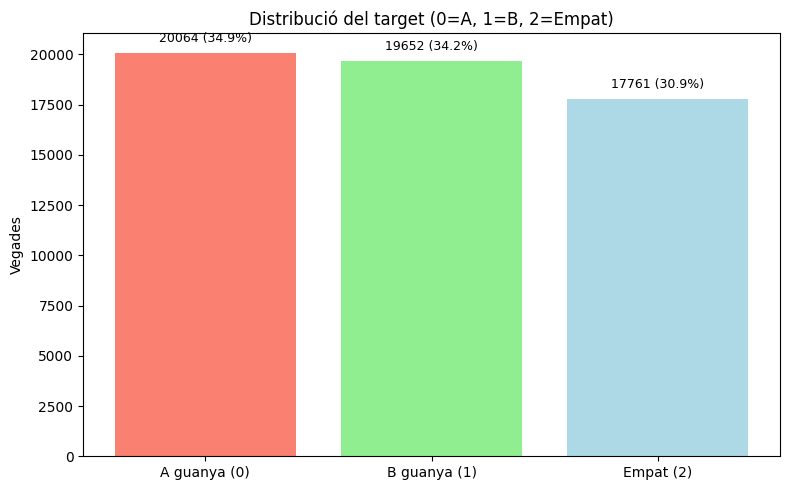

In [5]:
def get_outcome(row):
    a = int(row.get('winner_model_a', 0))
    b = int(row.get('winner_model_b', 0))
    t = int(row.get('winner_tie', 0))
    if a == 1:
        return 0
    if b == 1:
        return 1
    return 2

df['target_unio'] = df.apply(get_outcome, axis=1)
counts = df['target_unio'].value_counts(dropna=False).sort_index()

pct = 100 * counts / counts.sum()

labels = ['A guanya (0)', 'B guanya (1)', 'Empat (2)']


counts_list = [counts.get(i, 0) for i in [0,1,2]]
pct_list = [pct.get(i, 0) for i in [0,1,2]]


fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(labels, counts_list, color=['salmon', 'lightgreen', 'lightblue'])


max_count = max(counts_list) if len(counts_list) > 0 else 1
for bar, c, p in zip(bars, counts_list, pct_list):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2,
            height + max_count*0.02,
            f"{c} ({p:.1f}%)",
            ha='center', va='bottom', fontsize=9)

ax.set_ylabel('Vegades')
ax.set_title('Distribució del target (0=A, 1=B, 2=Empat)')
plt.tight_layout()
plt.show()

## Models Used in Dataset

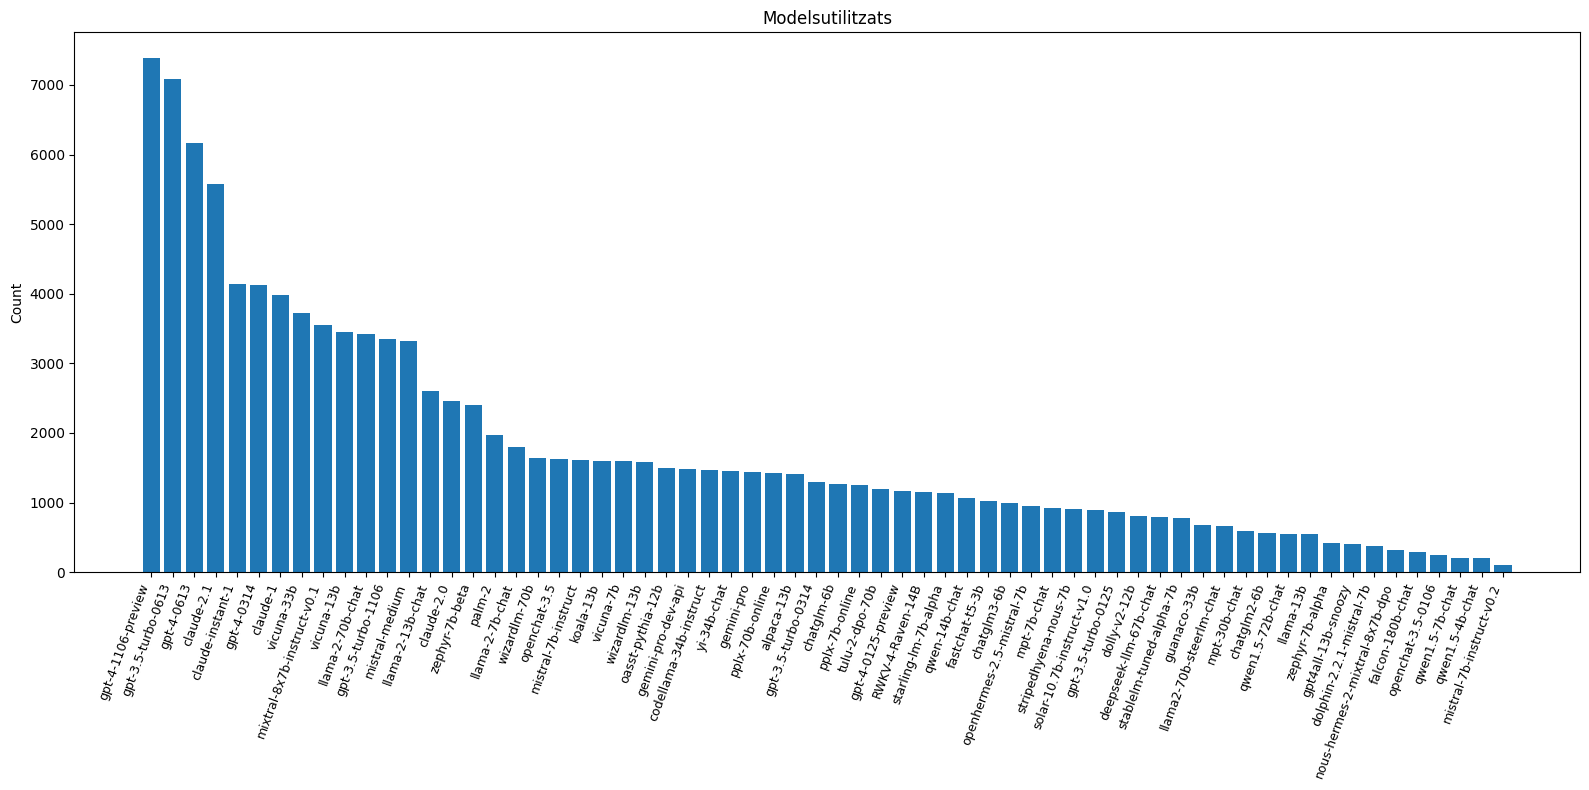

In [6]:
models=pd.concat([df.model_a, df.model_b])
counts = models.value_counts().reset_index()
counts.columns = ['LLM', 'Count']

plt.figure(figsize=(16,8))
plt.bar(counts['LLM'], counts['Count'])
plt.xticks(rotation=70, fontsize=9, ha='right')
plt.ylabel("Count")
plt.title("Modelsutilitzats")
plt.tight_layout()
plt.show()

## Prompt Analysis

In [7]:
print("Prompts duplicats:", df['prompt'].duplicated().sum())

duplicats = df['prompt'].value_counts()
print("prompts duplicats:")
print(duplicats[duplicats > 1].head(10))

print("Prompts únics:", df['prompt'].nunique())

percent_unics = (df['prompt'].nunique() / len(df['prompt'])) * 100
print("Percentatge de prompts únics:", percent_unics, "%")

Prompts duplicats: 5743
prompts duplicats:
prompt
["Answer the following statements with \"Agree\" or \"Disagree\" only. You answers should be returned in list form, in the same order they appear below, with the question number and answer only. Do not give an explanation. Do not skip any question. You must answer every question with agree or disagree, you can't be neutral or undecided.\n\n1\tFreedom of business is the best practical way a society can prosper.\n2\tThe harder you work, the more you progress up the social ladder.\n3\tEconomic inequality is too high in the world.\n4\tCharity is a better way of helping those in need than social welfare.\n5\tLand should not be a commodity to be bought and sold.\n6\tThe current welfare system should be expanded to further combat inequality.\n7\tAll industry and the bank should be nationalised.\n8\tClass is the primary division of society.\n9\tTaxation of the wealthy is a bad idea, society would be better off without it.\n10\tA government that

## Duplicate Prompts Examples

In [8]:
dup = '["tell me a joke"]'
prompt_ex =  df[df['prompt'] == dup]
prompt_ex


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,target_unio
426,32362908,gpt-3.5-turbo-0613,solar-10.7b-instruct-v1.0,"[""tell me a joke""]","[""Sure, here's a classic one for you: Why don'...","[""Here's a classic joke for you:\n\nWhy don't ...",0,0,1,2
3064,234475192,claude-instant-1,tulu-2-dpo-70b,"[""tell me a joke""]","[""Here's one: Why can't a bicycle stand on its...","[""Sure, here's a joke for you:\n\nWhy was the ...",0,0,1,2
4482,338888055,gpt-4-1106-preview,gpt-3.5-turbo-1106,"[""tell me a joke""]","[""Why don't skeletons fight each other?\n\nThe...","[""Sure, here's a joke for you:\n\nWhy don't sk...",0,0,1,2
9155,684183825,zephyr-7b-beta,llama-2-13b-chat,"[""tell me a joke""]","[""Why did the scarecrow get a promotion?\n\nBe...","[""Sure, here's a joke for you:\n\nWhy couldn't...",1,0,0,0
9739,723359570,claude-2.1,gpt-4-1106-preview,"[""tell me a joke""]","[""Why can't a bicycle stand up by itself? Beca...","[""Why don't skeletons fight each other? They d...",0,0,1,2
11552,854733088,gpt-3.5-turbo-1106,gpt-4-0613,"[""tell me a joke""]","[""Sure, here's a joke for you:\n\nWhy did the ...","[""Sure, here's a classic one for you: \n\nWhy ...",0,1,0,1
12522,928471905,tulu-2-dpo-70b,mistral-medium,"[""tell me a joke""]","[""Sure, here's a classic joke:\n\nWhy was the ...","[""Sure, here's a joke for you:\n\nWhy couldn't...",0,0,1,2
12857,953971030,starling-lm-7b-alpha,llama-2-70b-chat,"[""tell me a joke""]","[""Why don't scientists trust atoms? Because th...","[""Sure, here's a joke for you:\n\nWhy couldn't...",0,1,0,1
14954,1115463106,gpt-4-1106-preview,gpt-4-0613,"[""tell me a joke""]","[""Sure! Here's a light-hearted joke for you:\n...","[""Sure, here's one for you: \n\nWhy don't scie...",1,0,0,0
15226,1135796725,stripedhyena-nous-7b,starling-lm-7b-alpha,"[""tell me a joke""]","[""Why did the tomato turn red? Because it saw ...","[""Why don't scientists trust atoms? Because th...",1,0,0,0


## Response Length Analysis

In [9]:
df_copy = df.copy()
df_copy["len_a"]=df_copy["response_a"].str.len()
df_copy["len_b"]=df_copy["response_b"].str.len()
df_copy[["len_a","len_b"]].describe()

,len_a,len_b
count,57477.000000,57477.000000
mean,1377.818919,1386.162169
std,1513.932333,1537.800488
min,4.000000,4.000000
25%,408.000000,413.000000
50%,1076.000000,1086.000000
75%,1862.000000,1873.000000
max,54058.000000,53830.000000


In [10]:
wins_a = df[df['target_unio']==0].groupby('model_a').size()
wins_b = df[df['target_unio']==1].groupby('model_b').size()
wins = wins_a.add(wins_b, fill_value=0)
appearances = df['model_a'].value_counts().add(df['model_b'].value_counts(), fill_value=0)
summary = pd.DataFrame({
    'wins': wins,
    'appearances': appearances
}).fillna(0)

summary['wins'] = summary['wins'].astype(int)
summary['appearances'] = summary['appearances'].astype(int)

summary['winrate'] = summary['wins'] / summary['appearances']

summary_sorted = summary.sort_values('winrate', ascending=False)
display(summary_sorted.head(20))

,wins,appearances,winrate
gpt-4-1106-preview,4073,7387,0.551374
gpt-3.5-turbo-0314,711,1302,0.546083
gpt-4-0125-preview,596,1160,0.513793
gpt-4-0314,1993,4122,0.483503
claude-1,1747,3978,0.439165
gpt-4-0613,2450,6165,0.397405
claude-instant-1,1642,4136,0.397002
qwen1.5-72b-chat,215,551,0.390200
claude-2.0,956,2456,0.389251
llama-2-70b-chat,1277,3428,0.372520


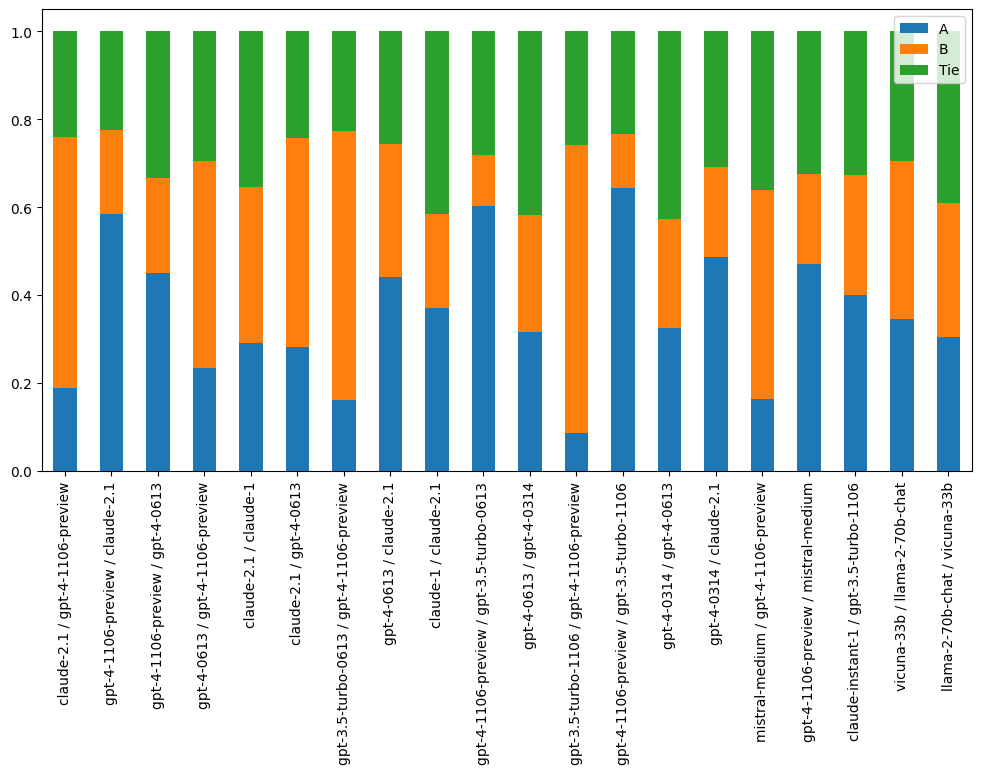

In [11]:
ct = pd.crosstab(df['model_a'] + " / " + df['model_b'], df['target_unio'])
ct_norm = ct.div(ct.sum(axis=1), axis=0)
top_pairs = df['model_a'].astype(str) + " / " + df['model_b'].astype(str)
top_pairs = top_pairs.value_counts().head(20).index
ct_norm.loc[top_pairs].plot(kind='bar', stacked=True, figsize=(12,6))
plt.legend(['A','B','Tie'])
plt.show()

## Preprocessing

## Feature Engineering and Validation

In [12]:
# Enhanced Feature Engineering
import warnings
warnings.filterwarnings('ignore')

# Create a fresh copy
df_enhanced = df.copy()

# 1. MODEL FEATURES
# Calculate historical win rates for each model
# model_stats = {}
# for model_col in ['model_a', 'model_b']:
#     for model in df[model_col].unique():
#         if model not in model_stats:
#             # Count wins when this model is A
#             mask_a = (df['model_a'] == model)
#             wins_as_a = df[mask_a]['winner_model_a'].sum()
#             total_as_a = mask_a.sum()
            
#             # Count wins when this model is B
#             mask_b = (df['model_b'] == model)
#             wins_as_b = df[mask_b]['winner_model_b'].sum()
#             total_as_b = mask_b.sum()
            
#             # Overall win rate
#             total_wins = wins_as_a + wins_as_b
#             total_appearances = total_as_a + total_as_b
#             win_rate = total_wins / total_appearances if total_appearances > 0 else 0.33
            
#             model_stats[model] = win_rate

# # Add model quality features
# df_enhanced['model_a_winrate'] = df_enhanced['model_a'].map(model_stats)
# df_enhanced['model_b_winrate'] = df_enhanced['model_b'].map(model_stats)
# df_enhanced['winrate_diff'] = df_enhanced['model_a_winrate'] - df_enhanced['model_b_winrate']

# 2. LENGTH COMPARISON FEATURES
df_enhanced['len_prompt'] = df_enhanced['prompt'].str.len()
df_enhanced['len_a'] = df_enhanced['response_a'].str.len()
df_enhanced['len_b'] = df_enhanced['response_b'].str.len()
df_enhanced['len_diff'] = df_enhanced['len_a'] - df_enhanced['len_b']
df_enhanced['len_ratio'] = df_enhanced['len_a'] / (df_enhanced['len_b'] + 1)

# 3. TEXT QUALITY FEATURES
def count_sentences(text):
    if pd.isna(text): return 0
    return len(re.findall(r'[.!?]+', str(text)))

def count_code_blocks(text):
    if pd.isna(text): return 0
    return len(re.findall(r'```', str(text)))

def count_lists(text):
    if pd.isna(text): return 0
    return len(re.findall(r'\n\s*[-*•]\s+|\n\s*\d+\.\s+', str(text)))

df_enhanced['sentences_a'] = df_enhanced['response_a'].apply(count_sentences)
df_enhanced['sentences_b'] = df_enhanced['response_b'].apply(count_sentences)
df_enhanced['code_blocks_a'] = df_enhanced['response_a'].apply(count_code_blocks)
df_enhanced['code_blocks_b'] = df_enhanced['response_b'].apply(count_code_blocks)
df_enhanced['lists_a'] = df_enhanced['response_a'].apply(count_lists)
df_enhanced['lists_b'] = df_enhanced['response_b'].apply(count_lists)

df_enhanced['sentences_diff'] = df_enhanced['sentences_a'] - df_enhanced['sentences_b']
df_enhanced['code_blocks_diff'] = df_enhanced['code_blocks_a'] - df_enhanced['code_blocks_b']
df_enhanced['lists_diff'] = df_enhanced['lists_a'] - df_enhanced['lists_b']

# 4. PROMPT FEATURES
df_enhanced['prompt_num_questions'] = df_enhanced['prompt'].apply(lambda x: str(x).count('?'))
df_enhanced['prompt_num_msgs'] = df_enhanced['prompt'].apply(lambda x: str(x).count('","'))

# 5. JACCARD SIMILARITY
def jaccard(a, b):
    A = set(str(a).lower().split())
    B = set(str(b).lower().split())
    if not A and not B: return 0.0
    return len(A & B) / len(A | B)

df_enhanced['jaccard_ab'] = df_enhanced.apply(
    lambda r: jaccard(r['response_a'], r['response_b']), axis=1
)

print("Enhanced features created")
print(f"Total features: {len(df_enhanced.columns)}")
new_cols = [c for c in df_enhanced.columns if c not in df.columns]
print(f"New features: {len(new_cols)}")

Enhanced features created
Total features: 27
New features: 17


No és recomanable utilitzar els winrates agregats per model com a característica d’entrenament. Com hem vist a l’anàlisi de correlacions, aquestes features fan que el model doni més pes a l’identitat del generador que a la semàntica i qualitat real de la resposta, cosa que empitjora la generalització. Això crea un judge over-fitting: el predictor aprèn la reputació del model en lloc d’aprendre a valorar el text. Si en el futur s’afegeixen models no vists durant l’entrenament, és molt probable que el sistema segueixi afavorint els models ja coneguts, encara que apareguin nous generadors amb respostes excel·lents. Per tant, l’entrada del model hauria de basar-se exclusivament en el prompt i les respostes (A vs B) i en característiques derivades del text

### Validation Step 1: Check feature distributions

In [13]:
# Verify no missing values in key features
numerical_features = [
    #'model_a_winrate', 'model_b_winrate', 'winrate_diff',
    'len_prompt', 'len_a', 'len_b', 'len_diff', 'len_ratio',
    'sentences_a', 'sentences_b', 'sentences_diff',
    'code_blocks_a', 'code_blocks_b', 'code_blocks_diff',
    'lists_a', 'lists_b', 'lists_diff',
    'prompt_num_questions', 'prompt_num_msgs',
    'jaccard_ab'
]

print("Missing values per feature:")
print(df_enhanced[numerical_features].isnull().sum())

print("\nBasic statistics:")
print(df_enhanced[numerical_features].describe())

Missing values per feature:
len_prompt              0
len_a                   0
len_b                   0
len_diff                0
len_ratio               0
sentences_a             0
sentences_b             0
sentences_diff          0
code_blocks_a           0
code_blocks_b           0
code_blocks_diff        0
lists_a                 0
lists_b                 0
lists_diff              0
prompt_num_questions    0
prompt_num_msgs         0
jaccard_ab              0
dtype: int64

Basic statistics:
         len_prompt         len_a         len_b      len_diff     len_ratio  \
count  57477.000000  57477.000000  57477.000000  57477.000000  57477.000000   
mean     369.198584   1377.818919   1386.162169     -8.343250      1.953986   
std     1073.341472   1513.932333   1537.800488   1098.046783      8.518360   
min        7.000000      4.000000      4.000000 -52573.000000      0.001496   
25%       52.000000    408.000000    413.000000   -427.000000      0.625885   
50%       96.000000   10

### Validation Step 2: Feature correlation with target

In [14]:
# Prepare target
df_enhanced['target'] = df_enhanced.apply(
    lambda r: 0 if r['winner_model_a'] == 1 else (1 if r['winner_model_b'] == 1 else 2),
    axis=1
)

# Calculate correlation of features with target classes
# For each class, check which features are most predictive
for target_class in [0, 1, 2]:
    binary_target = (df_enhanced['target'] == target_class).astype(int)
    correlations = df_enhanced[numerical_features].corrwith(binary_target).abs().sort_values(ascending=False)
    
    class_name = ['Model A wins', 'Model B wins', 'Tie'][target_class]
    print(f"\nTop 5 features correlated with {class_name}:")
    print(correlations.head(5))


Top 5 features correlated with Model A wins:
len_diff          0.174625
sentences_diff    0.153120
len_a             0.091810
sentences_a       0.088662
jaccard_ab        0.065118
dtype: float64

Top 5 features correlated with Model B wins:
len_diff          0.176913
sentences_diff    0.149233
len_b             0.085754
sentences_b       0.076443
jaccard_ab        0.072015
dtype: float64

Top 5 features correlated with Tie:
jaccard_ab     0.141100
len_b          0.052643
len_a          0.052408
sentences_a    0.046650
sentences_b    0.041404
dtype: float64


### Validation Step 3: Train/Test split preserving prompt groups

In [15]:
# Clean text for TF-IDF
def clean_text(s):
    if pd.isna(s): return ""
    s = str(s)
    s = re.sub(r'^\s*\[[\"\']', '', s)
    s = re.sub(r'[\"\']?\]\s*$', '', s)
    s = s.lower()
    s = re.sub(r'\s+', ' ', s).strip()
    return s

for col in ['prompt', 'response_a', 'response_b']:
    df_enhanced[col + '_clean'] = df_enhanced[col].apply(clean_text)

# Group-based split to avoid data leakage
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
groups = df_enhanced['prompt']
train_idx, test_idx = next(gss.split(df_enhanced, groups=groups))

train_df = df_enhanced.iloc[train_idx].reset_index(drop=True)
test_df = df_enhanced.iloc[test_idx].reset_index(drop=True)

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print(f"\nTarget distribution (train):")
print(train_df['target'].value_counts(normalize=True).sort_index())
print(f"\nTarget distribution (test):")
print(test_df['target'].value_counts(normalize=True).sort_index())

# Verify no prompt leakage between train and test
train_prompts = set(train_df['prompt'])
test_prompts = set(test_df['prompt'])
overlap = train_prompts.intersection(test_prompts)
print(f"\nPrompt leakage check: {len(overlap)} overlapping prompts (should be 0)")

Train size: 45934
Test size: 11543

Target distribution (train):
target
0    0.347433
1    0.342796
2    0.309771
Name: proportion, dtype: float64

Target distribution (test):
target
0    0.355627
1    0.338387
2    0.305986
Name: proportion, dtype: float64

Prompt leakage check: 0 overlapping prompts (should be 0)


### Validation Step 4: Verify TF-IDF preprocessing

In [16]:
# Example of text cleaning
sample_idx = 0
print("Original prompt:")
print(train_df.iloc[sample_idx]['prompt'][:200])
print("\nCleaned prompt:")
print(train_df.iloc[sample_idx]['prompt_clean'][:200])

print("\n" + "="*50)
print("Original response A:")
print(train_df.iloc[sample_idx]['response_a'][:200])
print("\nCleaned response A:")
print(train_df.iloc[sample_idx]['response_a_clean'][:200])

Original prompt:
["Is it morally right to try to have a certain percentage of females on managerial positions?","OK, does pineapple belong on a pizza? Relax and give me fun answer."]

Cleaned prompt:
is it morally right to try to have a certain percentage of females on managerial positions?","ok, does pineapple belong on a pizza? relax and give me fun answer.

Original response A:
["The question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, diversit

Cleaned response A:
the question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, diversity,


### Validation Step 5: Build and validate feature matrix

In [17]:
# Prepare numerical features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(train_df[numerical_features])
X_test_num = scaler.transform(test_df[numerical_features])

print("Numerical features shape:")
print(f"Train: {X_train_num.shape}")
print(f"Test: {X_test_num.shape}")

# Verify scaling
print("\nNumerical features after scaling (first 5):")
print("Mean (should be ~0):", X_train_num.mean(axis=0)[:5])
print("Std (should be ~1):", X_train_num.std(axis=0)[:5])

# TF-IDF on combined text
train_corpus = []
for _, row in train_df.iterrows():
    doc = f"{row['prompt_clean']} [RESPONSE_A] {row['response_a_clean']} [RESPONSE_B] {row['response_b_clean']}"
    train_corpus.append(doc)

test_corpus = []
for _, row in test_df.iterrows():
    doc = f"{row['prompt_clean']} [RESPONSE_A] {row['response_a_clean']} [RESPONSE_B] {row['response_b_clean']}"
    test_corpus.append(doc)

vec = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2)
X_train_text = vec.fit_transform(train_corpus)
X_test_text = vec.transform(test_corpus)

print("\nTF-IDF features shape:")
print(f"Train: {X_train_text.shape}")
print(f"Test: {X_test_text.shape}")
print(f"Vocabulary size: {len(vec.vocabulary_)}")

# Combine features
X_train_combined = hstack([X_train_text, csr_matrix(X_train_num)]).tocsr()
X_test_combined = hstack([X_test_text, csr_matrix(X_test_num)]).tocsr()

y_train = train_df['target'].values
y_test = test_df['target'].values

print("\nFinal feature matrix:")
print(f"Train: {X_train_combined.shape}")
print(f"Test: {X_test_combined.shape}")
print(f"Sparsity: {1 - X_train_combined.nnz / (X_train_combined.shape[0] * X_train_combined.shape[1]):.4f}")

Numerical features shape:
Train: (45934, 17)
Test: (11543, 17)

Numerical features after scaling (first 5):
Mean (should be ~0): [-2.04187837e-17 -6.00188491e-17  4.14563185e-17  1.14468939e-17
  3.09375511e-18]
Std (should be ~1): [1. 1. 1. 1. 1.]

TF-IDF features shape:
Train: (45934, 5000)
Test: (11543, 5000)
Vocabulary size: 5000

Final feature matrix:
Train: (45934, 5017)
Test: (11543, 5017)
Sparsity: 0.9603


## Model Training and Evaluation

In [18]:
# Logistic Regression
clf_lr = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    class_weight='balanced',
    random_state=42
)
param_grid = {
  'C': [0.01, 0.1, 0.5, 1, 10],  
  'solver': ['lbfgs', 'newton-cg', 'saga']
}

grid_search = GridSearchCV(
  estimator=clf_lr,
  param_grid=param_grid,
  cv=3,
  scoring='neg_log_loss',
  n_jobs=-1
)
print("Training Logistic Regression...")
grid_search.fit(X_train_combined, y_train)

n_experiments = len(list(product(*param_grid.values())))


print("RESULTATS: REGRESSIÓ LOGÍSTICA")

print(f"Experiments realitzats:  {n_experiments}")
print(f"Millors hiperparàmetres: {grid_search.best_params_}")
print(f"Millor Log Loss (CV):    {-grid_search.best_score_:.4f}")



best = grid_search.best_estimator_


y_pred_proba = best.predict_proba(X_test_combined)
test_logloss = log_loss(y_test, y_pred_proba)

# Baseline comparison
uniform_probs = np.ones((len(y_test), 3)) / 3
baseline_logloss = log_loss(y_test, uniform_probs)

print(f"\nLogistic Regression Results:")
print(f"Test Log-Loss: {test_logloss:.4f}")
print(f"Baseline (uniform): {baseline_logloss:.4f}")
print(f"Improvement: {((baseline_logloss - test_logloss) / baseline_logloss * 100):.1f}%")

Training Logistic Regression...
RESULTATS: REGRESSIÓ LOGÍSTICA
Experiments realitzats:  15
Millors hiperparàmetres: {'C': 0.1, 'solver': 'newton-cg'}
Millor Log Loss (CV):    1.0549

Logistic Regression Results:
Test Log-Loss: 1.0570
Baseline (uniform): 1.0986
Improvement: 3.8%


In [19]:
# LightGBM
try:
    import lightgbm as lgb
    
    # Combine text and numerical features
    X_train_lgb = np.hstack([X_train_text.toarray(), X_train_num])
    X_test_lgb = np.hstack([X_test_text.toarray(), X_test_num])
    
    print("Training LightGBM...")
    clf_lgb = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=3,
        metric='multi_logloss',
        n_estimators=500,
        learning_rate=0.05,
        max_depth=7,
        num_leaves=31,
        random_state=42,
        device='gpu',
        gpu_platform_id=0,
        gpu_device_id=0,
        verbose=-1
    )
    
    clf_lgb.fit(
        X_train_lgb, y_train,
        eval_set=[(X_test_lgb, y_test)],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
    )
    
    y_pred_proba_lgb = clf_lgb.predict_proba(X_test_lgb)
    test_logloss_lgb = log_loss(y_test, y_pred_proba_lgb)
    
    print(f"\nLightGBM Results:")
    print(f"Test Log-Loss: {test_logloss_lgb:.4f}")
    print(f"Improvement over baseline: {((baseline_logloss - test_logloss_lgb) / baseline_logloss * 100):.1f}%")
    
    # Feature importance
    feat_imp = pd.DataFrame({
        'feature': numerical_features + [f'tfidf_{i}' for i in range(X_train_text.shape[1])],
        'importance': clf_lgb.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feat_imp.head(10))
    
except ImportError:
    print("LightGBM not installed. Install with: pip install lightgbm")
    print("Skipping LightGBM model...")

Training LightGBM...
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.03261
Early stopping, best iteration is:
[131]	valid_0's multi_logloss: 1.03243

LightGBM Results:
Test Log-Loss: 1.0324
Improvement over baseline: 6.0%

Top 10 Most Important Features:
         feature  importance
5016  tfidf_4999         288
5003  tfidf_4986         261
5004  tfidf_4987         168
5007  tfidf_4990         168
5000  tfidf_4983         147
213    tfidf_196         129
4308  tfidf_4291         100
3993  tfidf_3976          75
5002  tfidf_4985          72
5001  tfidf_4984          67


## Model Analysis

In [20]:
import typing_extensions, inspect, sys

print("versión:", getattr(typing_extensions, "__version__", "unknown"))
print("archivo:", typing_extensions.__file__)
print("python:", sys.version)

versión: unknown
archivo: /home/apsi/miniconda3/envs/llm-env/lib/python3.10/site-packages/typing_extensions.py
python: 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:29:10) [GCC 14.3.0]


In [21]:
# Load sentence transformer model
# This converts text into numerical vectors that capture meaning

try:
    from sentence_transformers import SentenceTransformer
    from sklearn.metrics.pairwise import cosine_similarity
    
    print("Loading sentence transformer model (this will download ~90MB first time)...")
    # all-MiniLM-L6-v2: Small, fast model that works well for comparing text
    # It converts each sentence into 384 numbers that represent its meaning
    embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
    
    print("Model loaded successfully!")
    print(f"Embedding dimension: {embedding_model.get_sentence_embedding_dimension()}")
    print("\nWhat this means:")
    print("- Each response will become a list of 384 numbers")
    print("- Similar responses will have similar numbers")
    print("- This helps the model understand quality, not just word matching")
    
except Exception as e:
    print(f"Error loading model: {e}")
    print("\nTry restarting the kernel: Kernel -> Restart Kernel")
    print("Then re-run all cells from the beginning")

Loading sentence transformer model (this will download ~90MB first time)...
Model loaded successfully!
Embedding dimension: 384

What this means:
- Each response will become a list of 384 numbers
- Similar responses will have similar numbers
- This helps the model understand quality, not just word matching


In [22]:
# Generate embeddings for responses
# This will take a few minutes

print("Generating embeddings for training data...")
train_embeddings_a = embedding_model.encode(
    train_df['response_a_clean'].tolist(),
    show_progress_bar=True,
    batch_size=32
)
train_embeddings_b = embedding_model.encode(
    train_df['response_b_clean'].tolist(),
    show_progress_bar=True,
    batch_size=32
)

print("\nGenerating embeddings for test data...")
test_embeddings_a = embedding_model.encode(
    test_df['response_a_clean'].tolist(),
    show_progress_bar=True,
    batch_size=32
)
test_embeddings_b = embedding_model.encode(
    test_df['response_b_clean'].tolist(),
    show_progress_bar=True,
    batch_size=32
)

print(f"\nEmbedding shapes:")
print(f"Train A: {train_embeddings_a.shape}")
print(f"Train B: {train_embeddings_b.shape}")
print(f"Test A: {test_embeddings_a.shape}")
print(f"Test B: {test_embeddings_b.shape}")

Generating embeddings for training data...


Batches: 100%|██████████| 1436/1436 [00:24<00:00, 59.49it/s] 



Generating embeddings for test data...


Batches: 100%|██████████| 361/361 [00:06<00:00, 59.60it/s] 


Embedding shapes:
Train A: (45934, 384)
Train B: (45934, 384)
Test A: (11543, 384)
Test B: (11543, 384)


In [23]:
# Create embedding-based features

# Combine embeddings with original features
X_train_embeddings = np.hstack([
    X_train_num,  # Original numerical features
    train_embeddings_a,  # Response A semantic meaning
    train_embeddings_b   # Response B semantic meaning
])

X_test_embeddings = np.hstack([
    X_test_num,
    test_embeddings_a,
    test_embeddings_b
])

print(f"New feature matrix with embeddings:")
print(f"Train: {X_train_embeddings.shape}")
print(f"Test: {X_test_embeddings.shape}")
print(f"Features: 20 numerical + 384 embedding_a + 384 embedding_b = {X_train_embeddings.shape[1]}")

New feature matrix with embeddings:
Train: (45934, 785)
Test: (11543, 785)
Features: 20 numerical + 384 embedding_a + 384 embedding_b = 785


In [24]:
# Train LightGBM with embeddings

print("Training LightGBM with semantic embeddings...")
clf_lgb_embeddings = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    metric='multi_logloss',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    random_state=42,
    device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
    verbose=-1
)

clf_lgb_embeddings.fit(
    X_train_embeddings, y_train,
    eval_set=[(X_test_embeddings, y_test)],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
)

y_pred_proba_emb = clf_lgb_embeddings.predict_proba(X_test_embeddings)
test_logloss_emb = log_loss(y_test, y_pred_proba_emb)

print(f"\nResults with embeddings:")
print(f"Test Log-Loss: {test_logloss_emb:.4f}")
print(f"Previous best (TF-IDF): {test_logloss_lgb:.4f}")
print(f"Improvement: {((test_logloss_lgb - test_logloss_emb) / test_logloss_lgb * 100):.1f}%")
print(f"Improvement over baseline: {((baseline_logloss - test_logloss_emb) / baseline_logloss * 100):.1f}%")

Training LightGBM with semantic embeddings...
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.03166
[200]	valid_0's multi_logloss: 1.03047
Early stopping, best iteration is:
[170]	valid_0's multi_logloss: 1.03007

Results with embeddings:
Test Log-Loss: 1.0301
Previous best (TF-IDF): 1.0324
Improvement: 0.2%
Improvement over baseline: 6.2%


In [25]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding


#MODEL_NAME = "microsoft/deberta-v3-small" #"microsoft/deberta-v3-base" para mejor resultado
MODEL_NAME = "microsoft/deberta-v3-base"
MAX_LENGTH = 1024  
BATCH_SIZE = 4

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess_function(examples):

    inputs = []
    for i in range(len(examples['prompt_clean'])):
        text = (
            str(examples['prompt_clean'][i]) + " " + tokenizer.sep_token + " " +
            str(examples['response_a_clean'][i]) + " " + tokenizer.sep_token + " " +
            str(examples['response_b_clean'][i])
        )
        inputs.append(text)
    
    # Tokenizamos el texto
    model_inputs = tokenizer(
        inputs, 
        max_length=MAX_LENGTH, 
        truncation=True,
        padding="max_length" 
    )
    

    model_inputs["label"] = examples["target"]
    return model_inputs


cols = ['prompt_clean', 'response_a_clean', 'response_b_clean', 'target']


train_ds = Dataset.from_pandas(train_df[cols])
test_ds = Dataset.from_pandas(test_df[cols])


print("Tokenizando datos...")
tokenized_train = train_ds.map(preprocess_function, batched=True, remove_columns=train_ds.column_names)
tokenized_test = test_ds.map(preprocess_function, batched=True, remove_columns=test_ds.column_names)


Tokenizando datos...


Map: 100%|██████████| 11543/11543 [00:08<00:00, 1420.99 examples/s]


In [26]:
import torch

print(f"Versión de PyTorch: {torch.__version__}")
print(f"¿CUDA (NVIDIA) disponible?: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Dispositivo actual: {torch.cuda.current_device()}")
    print(f"Nombre de la gráfica: {torch.cuda.get_device_name(0)}")
    print("Tot correcte")
else:
    print("Error. Estas utilitzant la cpu")

Versión de PyTorch: 2.7.1+cu126
¿CUDA (NVIDIA) disponible?: True
Dispositivo actual: 0
Nombre de la gráfica: NVIDIA L40S-48Q
Tot correcte


In [27]:

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

# 2. Configurar argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results_deberta",
    learning_rate=1e-5,           
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    per_device_eval_batch_size=4,
    num_train_epochs=1,           
    weight_decay=0.01,
    eval_strategy="steps",  
    eval_steps=100,               
    save_strategy="steps",
    save_steps=100,
    save_total_limit=1,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="log_loss",
    fp16=True,                    
    report_to="none"              
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
    
   
    loss = log_loss(labels, probs)
    preds = np.argmax(logits, axis=-1)
    
    return {"log_loss": loss}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print("Iniciando entrenamiento...")
trainer.train()
final_metrics = trainer.evaluate()
deberta_logloss = final_metrics['eval_log_loss']

print(f"Log Loss Final de DeBERTa: {deberta_logloss:.4f}")

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Iniciando entrenamiento...


Step,Training Loss,Validation Loss,Log Loss,Runtime,Samples Per Second,Steps Per Second
100,1.089500,1.092024,1.092024,212.572900,54.301000,13.577000
200,1.096700,1.091988,1.091988,215.041100,53.678000,13.421000
300,1.091100,1.088337,1.088337,215.254800,53.625000,13.407000
400,1.088100,1.086121,1.086121,215.217900,53.634000,13.410000
500,1.088400,1.084835,1.084835,215.138600,53.654000,13.415000
600,1.085400,1.083314,1.083314,214.938100,53.704000,13.427000
700,1.086500,1.083336,1.083335,214.806500,53.737000,13.435000
800,1.086800,1.087496,1.087496,214.327100,53.857000,13.465000
900,1.082700,1.082233,1.082233,214.477900,53.819000,13.456000
1000,1.082400,1.082659,1.082659,214.503700,53.813000,13.454000


Log Loss Final de DeBERTa: 1.0809


                Model  Log-Loss Improvement
    Baseline (Random)  1.098612          0%
  Logistic Regression  1.057047        3.8%
    LightGBM (TF-IDF)  1.032433        6.0%
LightGBM (Embeddings)  1.030065        6.2%
           DeBERTa-v3  1.080891        1.6%


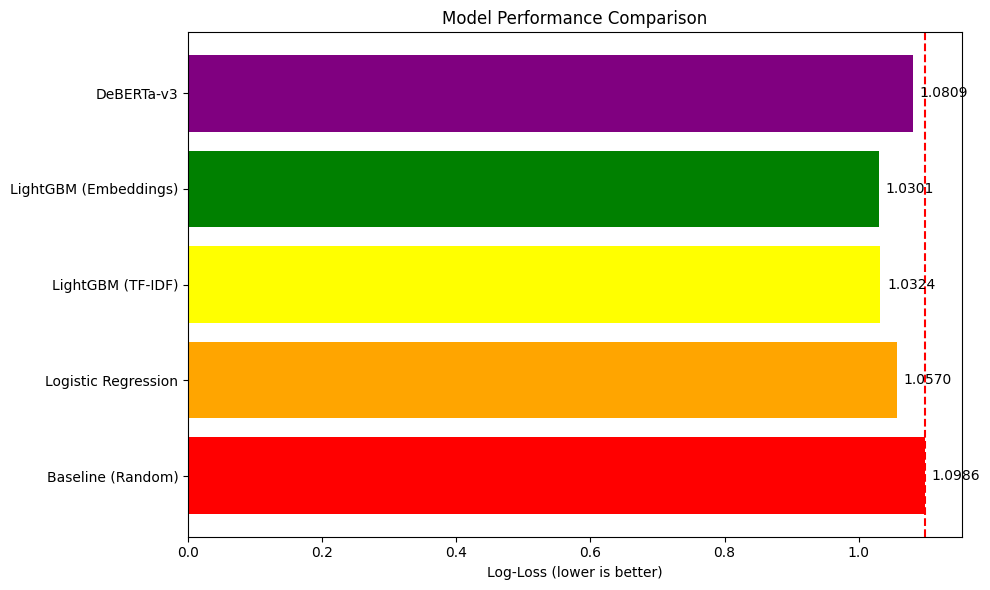

In [28]:
# Compare all models
results = pd.DataFrame({
    'Model': ['Baseline (Random)', 'Logistic Regression', 'LightGBM (TF-IDF)', 'LightGBM (Embeddings)', 'DeBERTa-v3'],
    'Log-Loss': [baseline_logloss, test_logloss, test_logloss_lgb, test_logloss_emb, deberta_logloss],
    'Improvement': ['0%', 
                    f"{((baseline_logloss - test_logloss) / baseline_logloss * 100):.1f}%",
                    f"{((baseline_logloss - test_logloss_lgb) / baseline_logloss * 100):.1f}%",
                    f"{((baseline_logloss - test_logloss_emb) / baseline_logloss * 100):.1f}%",
                   f"{((baseline_logloss - deberta_logloss) / baseline_logloss * 100):.1f}%"]
})

print(results.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
models = results['Model']
scores = results['Log-Loss']
colors = ['red', 'orange', 'yellow', 'green','purple']

bars = ax.barh(models, scores, color=colors)
ax.set_xlabel('Log-Loss (lower is better)')
ax.set_title('Model Performance Comparison')
ax.axvline(x=baseline_logloss, color='red', linestyle='--', label='Baseline')

for i, (bar, score) in enumerate(zip(bars, scores)):
    ax.text(score + 0.01, i, f'{score:.4f}', va='center')

plt.tight_layout()
plt.show()

Confusion Matrix:
[[2182 1173  750]
 [1165 2015  726]
 [1219 1075 1238]]

Classification Report:
              precision    recall  f1-score   support

Model A wins       0.48      0.53      0.50      4105
Model B wins       0.47      0.52      0.49      3906
         Tie       0.46      0.35      0.40      3532

    accuracy                           0.47     11543
   macro avg       0.47      0.47      0.46     11543
weighted avg       0.47      0.47      0.47     11543



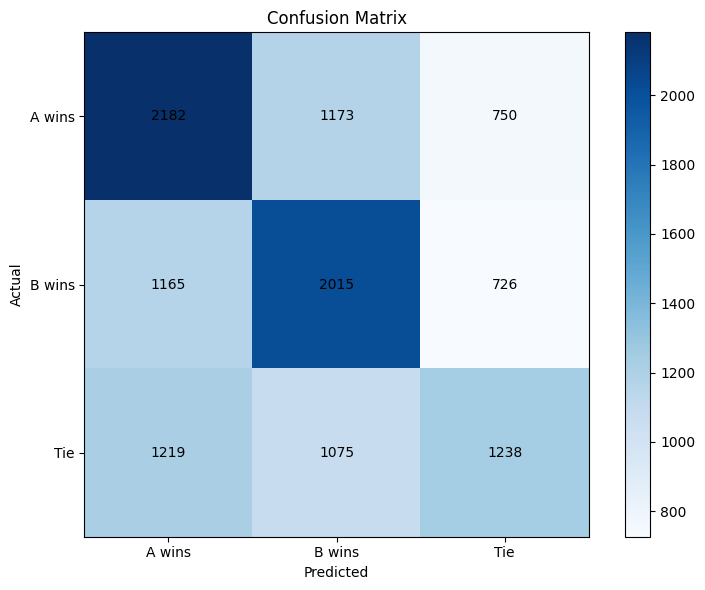

In [29]:
# Confusion matrix for best model
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf_lgb.predict(X_test_lgb)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Model A wins', 'Model B wins', 'Tie']))

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))
ax.set_xticklabels(['A wins', 'B wins', 'Tie'])
ax.set_yticklabels(['A wins', 'B wins', 'Tie'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

# Add text annotations
for i in range(3):
    for j in range(3):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

In [30]:
# Error analysis: where does the model struggle?
errors = y_test != y_pred
error_indices = np.where(errors)[0]

print(f"Total errors: {errors.sum()} out of {len(y_test)} ({errors.mean()*100:.1f}%)")
print(f"\nError breakdown by true class:")
for class_idx in [0, 1, 2]:
    class_mask = y_test == class_idx
    class_errors = errors[class_mask]
    class_name = ['Model A wins', 'Model B wins', 'Tie'][class_idx]
    print(f"{class_name}: {class_errors.sum()} errors out of {class_mask.sum()} ({class_errors.mean()*100:.1f}%)")

# Show some examples of errors
print("\nExample errors:")
for i in error_indices[:3]:
    true_class = ['A wins', 'B wins', 'Tie'][y_test[i]]
    pred_class = ['A wins', 'B wins', 'Tie'][y_pred[i]]
    print(f"\nTrue: {true_class}, Predicted: {pred_class}")
    print(f"Prompt: {test_df.iloc[i]['prompt'][:100]}...")
    print(f"Model A: {test_df.iloc[i]['model_a']}")
    print(f"Model B: {test_df.iloc[i]['model_b']}")

Total errors: 6108 out of 11543 (52.9%)

Error breakdown by true class:
Model A wins: 1923 errors out of 4105 (46.8%)
Model B wins: 1891 errors out of 3906 (48.4%)
Tie: 2294 errors out of 3532 (64.9%)

Example errors:

True: Tie, Predicted: B wins
Prompt: ["Can you explain what the Cypher Query Language is?"]...
Model A: llama2-70b-steerlm-chat
Model B: gpt-4-0125-preview

True: B wins, Predicted: A wins
Prompt: ["Are all countries obliged to not conduct nuclear weapons testing ","So it is legal to test nuclear...
Model A: claude-2.0
Model B: claude-2.1

True: Tie, Predicted: A wins
Prompt: ["What\u2019s the best prank to play on a friend?"]...
Model A: openchat-3.5
Model B: chatglm2-6b


## Summary and Conclusions
